In [57]:
# Import TF and TF Hub libraries.
import tensorflow as tf

# Load the input image.
image_path = 'woman2.jpg'
image = tf.io.read_file(image_path)
image = tf.compat.v1.image.decode_jpeg(image)
image = tf.expand_dims(image, axis=0)
# Resize and pad the image to keep the aspect ratio and fit the expected size.
image = tf.image.resize_with_pad(image, 256, 256)

# Initialize the TFLite interpreter
model_path = '4.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# TF Lite format expects tensor type of float32.
input_image = tf.cast(image, dtype=tf.uint8)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], input_image.numpy())

interpreter.invoke()

# Output is a [1, 1, 17, 3] numpy array.
keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])

print(keypoints_with_scores)



[[[[0.32993308 0.5335903  0.63865983]
   [0.3162015  0.5518828  0.8077101 ]
   [0.3154275  0.5109687  0.81729615]
   [0.33710155 0.5753322  0.79831725]
   [0.3377854  0.48209327 0.7698364 ]
   [0.42581913 0.63671565 0.8899432 ]
   [0.4316285  0.40797254 0.88299394]
   [0.5980589  0.6815487  0.78151983]
   [0.58204705 0.34648415 0.72743535]
   [0.51556796 0.6679326  0.7508376 ]
   [0.5719021  0.38426283 0.56430876]
   [0.71239734 0.59247994 0.794531  ]
   [0.7068172  0.4714014  0.7459195 ]
   [0.80815214 0.5606133  0.09858055]
   [0.7925586  0.48168567 0.0922474 ]
   [0.7932995  0.3901204  0.13735925]
   [0.80052006 0.56089735 0.03868447]]]]


In [58]:
import numpy as np
import cv2
from segment_anything import SamPredictor, sam_model_registry
from skimage import io
from matplotlib import pyplot as plt

import torch

from skimage import filters
from skimage.data import camera
from skimage.util import compare_images
import cv2

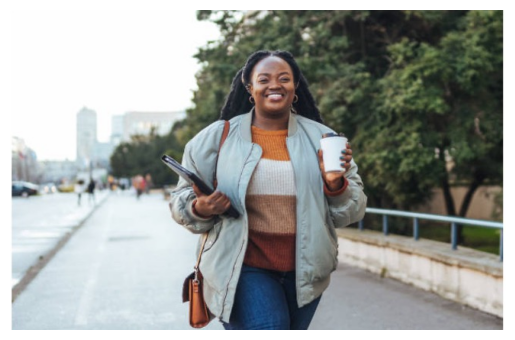

In [59]:

img = cv2.imread('woman2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(img)
plt.show()

In [60]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

Berechnenen der Position auf dem Bild:

In [61]:
print("nose")
print(keypoints_with_scores[0][0][0])
print("left shoulder")
print(keypoints_with_scores[0][0][5])
print("right hip")
print(keypoints_with_scores[0][0][12])
print("left knee")
print(keypoints_with_scores[0][0][13])


nose
[0.32993308 0.5335903  0.63865983]
left shoulder
[0.42581913 0.63671565 0.8899432 ]
right hip
[0.7068172 0.4714014 0.7459195]
left knee
[0.80815214 0.5606133  0.09858055]


In [62]:
# Größe des Arrays definieren
rows = 4
cols = 2

# Initialisierung des leeren Arrays
array = []
points = np.array([0,5,12,13])
input_label = np.array([1, 1, 1, 1])

# For-Schleife zum Erstellen des Arrays
for i in range(rows):
    # Eine leere Zeile für jede Iteration hinzufügen
    array.append([])
    point = keypoints_with_scores[0][0][points[i]]
    for j in range(cols):
        # Wert zu jeder Zeile hinzufügen
        array[i].append(point[j])

# Ausgabe des Arrays
print(array)

[[0.32993308, 0.5335903], [0.42581913, 0.63671565], [0.7068172, 0.4714014], [0.80815214, 0.5606133]]


In [63]:
input_points = []

for x in range(4):
    input_points.append([])
    withc = img.shape[1]
    x_coor = array[x][0] * withc
    height = img.shape[0]
    y_coor = array[x][0] * height
    input_points[x].append(x_coor) # erste Koordinate
    input_points[x].append(y_coor) # zweite Koordinate

print(input_points)

[[214.4565001130104, 138.57189238071442], [276.7824336886406, 178.844034075737], [459.4311863183975, 296.86322808265686], [525.2988904714584, 339.42389845848083]]


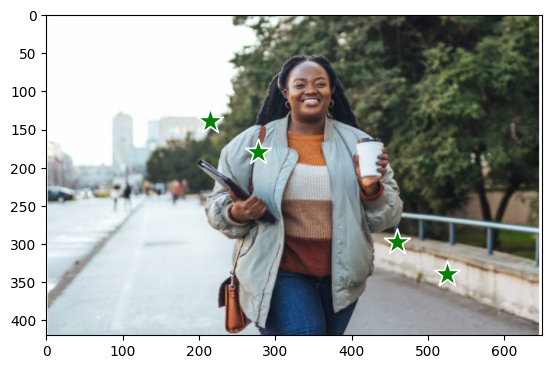

In [64]:
input_label = np.array([1, 1, 1, 1])
ip = np.array(input_points)
show_points(ip, input_label, plt.gca())
plt.axis('on')
plt.imshow(img)
plt.show() 